# Setup

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL/DefEfficientnet

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/ANNDL/DefEfficientnet


In [ ]:
import numpy as np
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl
seed = 8 # We chose 8 since the group is called 8pesto
np.random.seed(seed)
tf.random.set_seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# Dataset preprocessing

In [ ]:
# Load the original data
data = np.load('training_set.npz')
X = data['images']
y = data['labels']
print(X.shape)
print(y.shape)

(13759, 96, 96, 3)
(13759, 1)


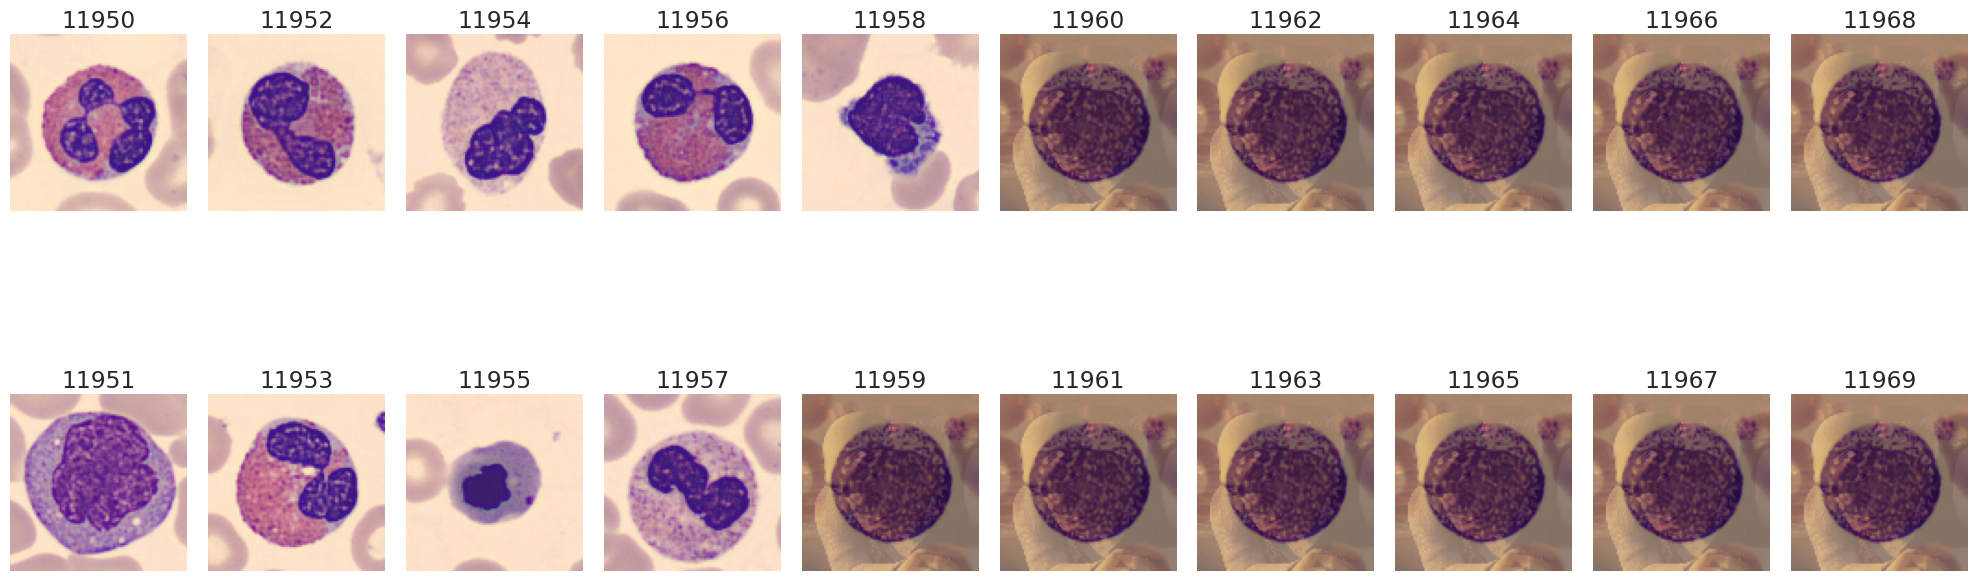

In [ ]:
# Through visual inspection we found several outliers, starting from index 11959
num_img=20

fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(X[11950+i]/255, 0, 1))
    ax.axis('off')
    #For each image we show the index to highlight the starting point of the outlier sequence
    ax.set_title(11950+i, pad=5)

plt.tight_layout()
plt.show()

In [ ]:
# We removed the outliers, printed the classes' distribution and noticed some imbalances
X = X[:11959]
y = y[:11959]
print('X shape:',X.shape)
print('y shape:',y.shape)

count=np.zeros(8)
for i in range(len(y)):
  count[y[i]]+=1
print('Class distribution:',count)

X shape: (11959, 96, 96, 3)
y shape: (11959, 1)
Class distribution: [ 852. 2181. 1085. 2026.  849.  993. 2330. 1643.]


We applied AugMix to the input, because we noticed it improved the overall performance.

In [ ]:
pip install keras-cv

In [ ]:
import keras_cv
from keras_cv.layers import AugMix

In [ ]:
# We chose quite a high severity (0.7), and a chain depth equal to 5
augmix = keras_cv.layers.AugMix([0, 255],severity=0.7,chain_depth=5)
X = augmix(X)

In [ ]:
# We saved a copy of the augmented dataset, without outliers
np.savez_compressed('AugmixCompleto.npz', images=X, labels=y)

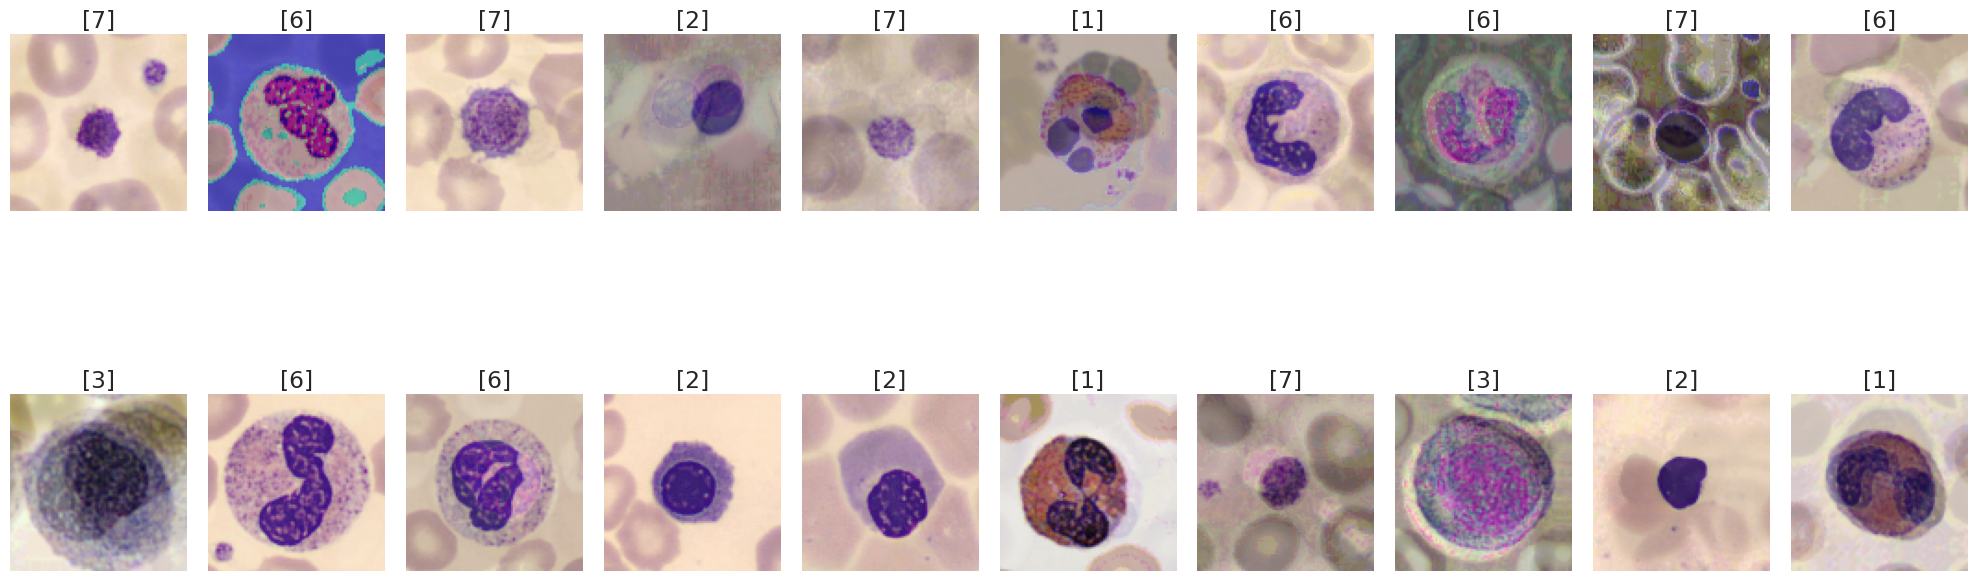

In [ ]:
# Visualisation of the new augmented dataset
num_img=20

fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(X[i]/255, 0, 1))
    ax.axis('off')
    ax.set_title(y[i], pad=5)

plt.tight_layout()
plt.show()

# Import of the preprocessed dataset

In [ ]:
# We loaded the preprocessed data
#data = np.load('AugmixCompleto.npz')
#X = data['images']
#y = data['labels']
print(X.shape)
print(y.shape)

(11959, 96, 96, 3)
(11959, 1)


In [ ]:
# We applied a random permutation
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

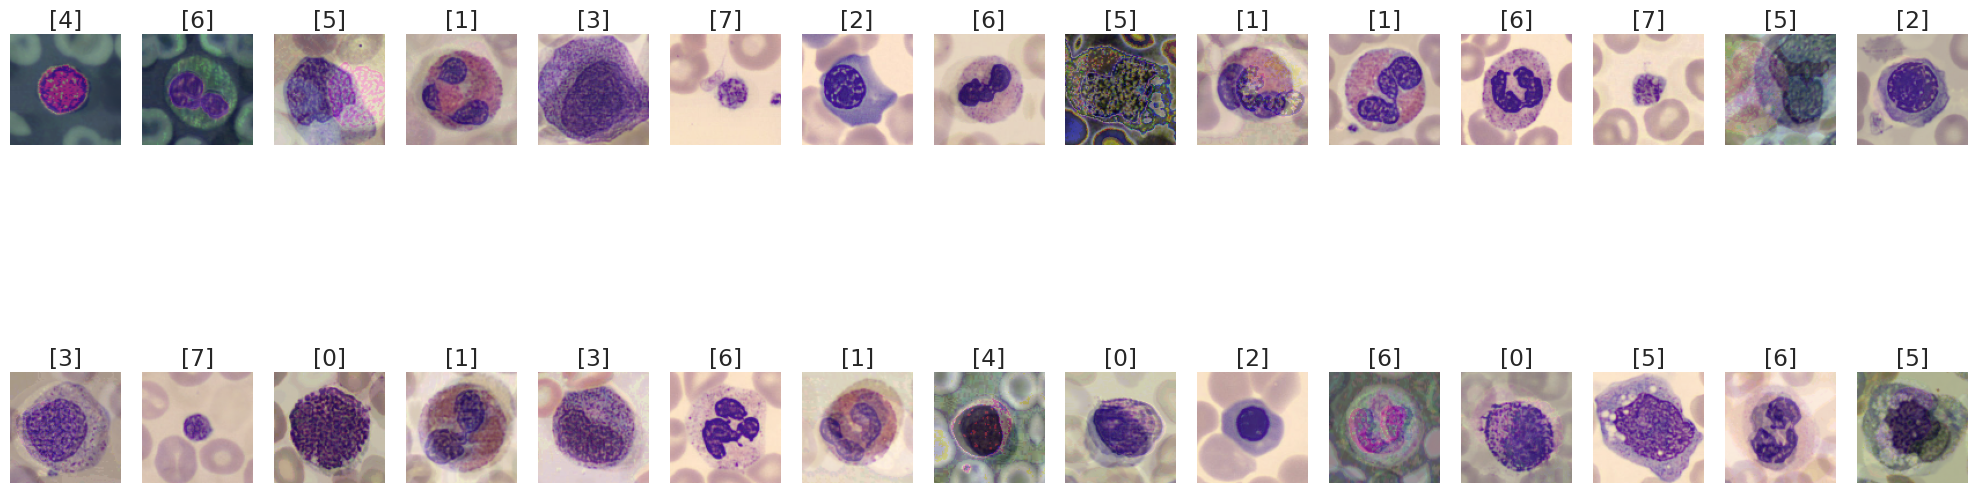

In [ ]:
# We visualised a sample of the data
num_img=30

fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(X[i]/255, 0, 1))
    ax.axis('off')
    ax.set_title(y[i], pad=5)

plt.tight_layout()
plt.show()

# Class weights and dataset split

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

num_classes = 8

# We computed the class weights and than used this data inside the Categorical Focal Crossentropy function
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=y[:,-1]
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.7545481220657277, 1: 0.6854080696928014, 2: 1.3777649769585254, 3: 0.7378455083909181, 4: 1.7607479387514724, 5: 1.5054128902316213, 6: 0.6415772532188841, 7: 0.9098447961046866}


We decided to split just in training and validation, since all the models we tested performed really well on the data we were provided with, so a test set would not reflect the real performance on the secret test set and would only take away data from the training set.

In [ ]:
# Split data set into train and validatio sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.03, stratify=y)

# Convert class labels to categorical format for training and validation
y_train = tfk.utils.to_categorical(y_train, num_classes=8)
y_val = tfk.utils.to_categorical(y_val, num_classes=8)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (11600, 96, 96, 3), y_train shape: (11600, 8)
X_val shape: (359, 96, 96, 3), y_val shape: (359, 8)


# EfficientNetV2M implementation

We decided to show just the final implementation with EfficientNetV2M because, as said in the report, we tried different architectures and each of them performed well on the training data we were provided with, but the real difference was in the accuracy score on Codabench, so comparing the performance of other implementations on our training set would not reflect the real results obtained on Codabench.

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
# We initialise the model with pretrained weights from imagenet, and we opted for average pooling
EFFNet = tfk.applications.EfficientNetV2M(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    include_preprocessing=True
)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
tf.random.set_seed(seed)

# We defined a regulariser and we used it in the dense layers
regulariser = tfk.regularizers.l2(0.01)

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Apply data augmentation for training robustness
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomRotation(0.3),
    tfkl.RandomTranslation(0.2, 0.2),
    tfkl.RandomContrast(0.3),
    tfkl.RandomBrightness(0.4),
    tfkl.RandomZoom(0.3),
], name='preprocessing')

x = preprocess_input(inputs)
x = augmentation(x)
x = EFFNet(x)

# After the feature extractor, we added batch normalization and a sequence of dense and dropout layers
x = tfkl.BatchNormalization(name="bnorm")(x)
x = tfkl.Dense(256, activation='relu', kernel_regularizer=regulariser, name='dense1')(x)
x = tfkl.Dropout(0.3, name='dropout1')(x)
x = tfkl.Dense(64, activation='relu',kernel_regularizer=regulariser, name='dense2')(x)
x = tfkl.Dropout(0.2, name='dropout2')(x)
outputs = tfkl.Dense(8, activation='softmax', name='densef')(x)

# Define the complete model linking input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical Focal cross-entropy loss and AdamW optimizer
model.compile(loss=tfk.losses.CategoricalFocalCrossentropy(gamma=2.0, alpha=np.array(list(class_weights.values()))), optimizer=tfk.optimizers.AdamW(1e-4), metrics=['accuracy'])

In [ ]:
# Set all layers as non-trainable
for layer in model.get_layer('efficientnetv2-m').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(model.get_layer('efficientnetv2-m').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True

# Set the number of layers to freeze
print(i) #we printed the number of layers and we chose N accordingly
N = 640

# We set the first N layers as non-trainable
for i, layer in enumerate(model.get_layer('efficientnetv2-m').layers[:N]):
    layer.trainable = False

# Display a summary of the model architecture
model.summary(expand_nested=True)

# Compile the model
model.compile(loss=tfk.losses.CategoricalFocalCrossentropy(gamma=2.0,alpha=np.array(list(class_weights.values()))), optimizer=tfk.optimizers.AdamW(1e-4), metrics=['accuracy'])

740


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation              │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast                 │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness               │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-m (Functional)        │ (None, 1280)                │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 24)          │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 24)          │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 53,500,412 (204.09 MB)

 Trainable params: 20,877,004 (79.64 MB)

 Non-trainable params: 32,623,408 (124.45 MB)

Since the architecture is very big, we print just a summary with all the layers of EfficientNetV2M nested in the functional part.

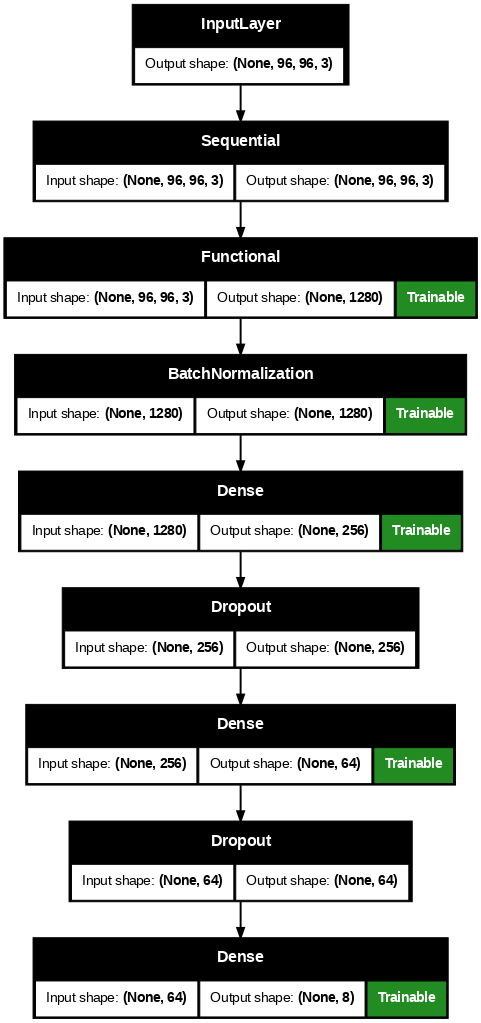

In [ ]:
tfk.utils.plot_model(model, expand_nested=False, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# We chose the batch size, the number of epochs and the patience
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'AdamW3V2M.keras'

model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 90s 402ms/step - accuracy: 0.3017 - loss: 6.7809 - val_accuracy: 0.6741 - val_loss: 5.9991
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 63s 267ms/step - accuracy: 0.5788 - loss: 5.6908 - val_accuracy: 0.7660 - val_loss: 5.1921
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 269ms/step - accuracy: 0.6524 - loss: 5.1773 - val_accuracy: 0.7577 - val_loss: 4.6854
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.6792 - loss: 4.7670 - val_accuracy: 0.7939 - val_loss: 4.2498
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.7121 - loss: 4.3672 - val_accuracy: 0.8189 - val_loss: 3.8579
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - accuracy: 0.7215 - loss: 4.0100 - val_accuracy: 0.8162 - val_loss: 3.5448
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.7342 - loss: 3.6480 - val_accuracy: 0.8273 - val_loss: 3.2018
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.7390 - loss: 3.3214 - 

On the validation set we obtained an accuracy of 90.81%, this value would be much higher if we had used a validation set without augmentation, but since we belive that the secret test set is more similar to the augmented one than to the original one, we think that this number is more meaningful.

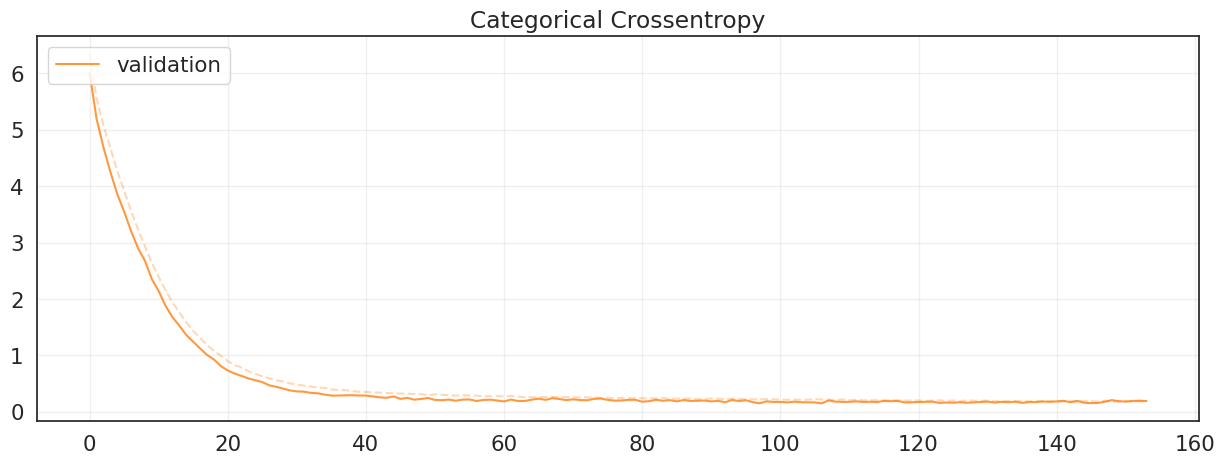

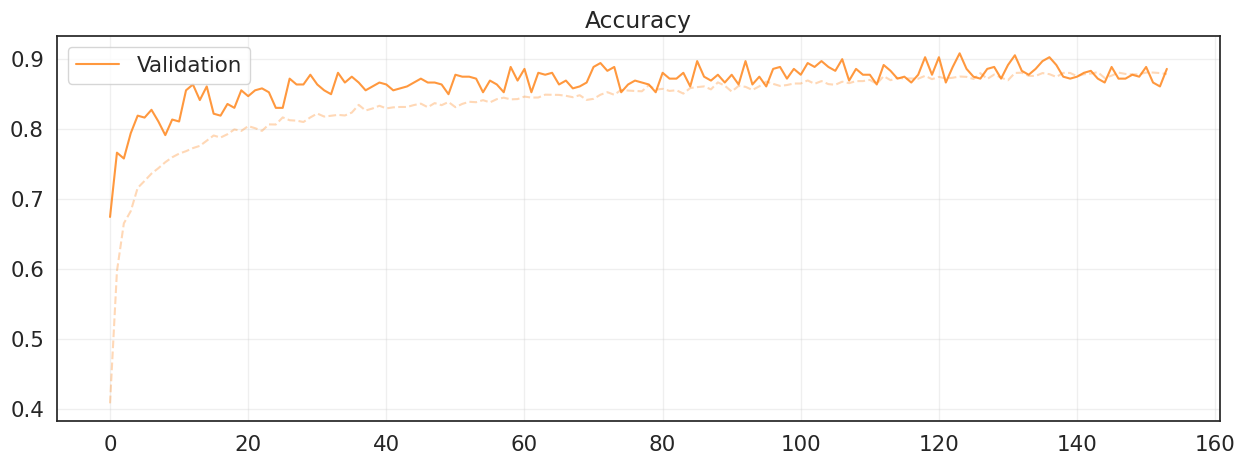

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Definition of model file, using TTA

In [ ]:
%%writefile model.py
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('AdamW3V2M.keras')


    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        # We defined the augmentation we wanted to apply on the test data
        augmentation = tf.keras.Sequential([
         tfkl.RandomFlip('horizontal_and_vertical'),
         tfkl.RandomRotation(0.3),
         tfkl.RandomTranslation(0.2, 0.2),
         tfkl.RandomContrast(0.3),
         tfkl.RandomBrightness(0.3),
         tfkl.RandomZoom(0.2),
        ], name='preprocessingaug')

        le=len(X) # We saved the length of the input, which will be usefull later

        # We made the first prediction with the original data
        preds1 = self.neural_network.predict(X)

        # We made 4 more predictions using augmentation on the input data
        K=augmentation(X)
        preds2 = self.neural_network.predict(K)
        K=augmentation(X)
        preds3 = self.neural_network.predict(K)
        K=augmentation(X)
        preds4 = self.neural_network.predict(K)
        K=augmentation(X)
        preds5 = self.neural_network.predict(K)

        # We combined the results of the 5 predictions
        k=np.zeros((le,8))
        for j in range(le):
            k[j]=preds1[j]+preds2[j]+preds3[j]+preds4[j]+preds5[j]
        val = np.argmax(k, axis=-1)
        return val

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py AdamW3V2M.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 62%)
  adding: AdamW3V2M.keras (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Other tests on the validation set

In [ ]:
from model import Model

# Inizialize the model
model = Model()

# Load the validation data
X_test = X_val
y_test = np.argmax(y_val, axis=-1)

# Make predictions
y_pred = model.predict(X_test)

# Show the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuratezza:", accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step
Accuratezza: 0.9721448467966574


This shows that TTA improves the performance of the model

Accuracy score over the validation set: 0.9721
Precision score over the validation set: 0.9734
Recall score over the validation set: 0.9721
F1 score over the validation set: 0.9721


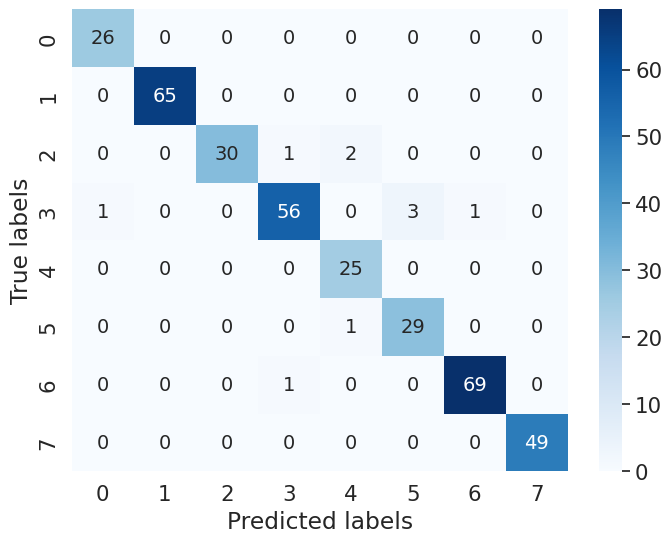

In [ ]:
# Save the predicted value
test_predictions = y_pred

# Extract ground truth classes
test_gt = y_test

# Calculate and display validation set accuracy after TTA
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the validation set: {round(test_accuracy, 4)}')

# Calculate and display validation set precision after TTA
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the validation set: {round(test_precision, 4)}')

# Calculate and display validation set recall after TTA
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the validation set: {round(test_recall, 4)}')

# Calculate and display validation set F1 score after TTA
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the validation set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()